In [51]:
import sys, os, re, pickle
import pandas as pd
from collections import defaultdict
from openbabel import openbabel as ob

os.chdir(os.environ['LIGAN_ROOT'])
import liGAN

os.getcwd()

'/net/pulsar/home/koes/mtr22/gan'

In [25]:
data_file = 'data/it2_tt_0_lowrmsd.types'
data_root = '/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output'
src_pat = re.compile(r'(.+)_(\d+)')

with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [53]:
def getNumHydrogens(ob_atom):
    return ob_atom.GetTotalDegree() - ob_atom.GetHvyDegree()

funcs = [
    ob.OBAtom.GetAtomicNum, 
    ob.OBAtom.IsAromatic,
    ob.OBAtom.IsHbondAcceptor,
    ob.OBAtom.IsHbondDonor,
    ob.OBAtom.GetFormalCharge,
    getNumHydrogens,
]

def defaultdict_int(): # allow pickling
    return defaultdict(int)

rec_counts = defaultdict(defaultdict_int)
lig_counts = defaultdict(defaultdict_int)

line_idx = 0
with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [43]:
while line_idx < n_lines:
    line = lines[line_idx]
    rec_src, lig_src = line.rstrip().split(' ')[3:5]
    rec_src_no_ext = os.path.splitext(rec_src)[0]
    lig_src_no_ext = os.path.splitext(lig_src)[0]

    m = src_pat.match(rec_src_no_ext)
    rec_mol_base = m.group(1) + '.pdb'
    rec_idx = int(m.group(2))
    rec_mol_file = os.path.join(data_root, rec_mol_base)
    rec_mol = liGAN.molecules.read_ob_mols_from_file(rec_mol_file, '.pdb')[rec_idx]

    m = src_pat.match(lig_src_no_ext)
    lig_mol_base = m.group(1) + '.sdf'
    lig_idx = int(m.group(2))
    lig_mol_file = os.path.join(data_root, lig_mol_base)
    lig_mol = liGAN.molecules.read_ob_mols_from_file(lig_mol_file, '.sdf')[lig_idx]

    for atom in ob.OBMolAtomIter(rec_mol):
        for func in funcs:
            rec_counts[func.__name__][func(atom)] += 1

    for atom in ob.OBMolAtomIter(lig_mol):
        for func in funcs:
            lig_counts[func.__name__][func(atom)] += 1

    line_idx += 1
    if line_idx % 100 == 0: 
        pct_done = line_idx/n_lines * 100
        print('[{:.2f}%]'.format(pct_done), end=' ')
        
        with open('rec_counts.pkl', 'wb') as f:
            pickle.dump(rec_counts, f)
        with open('lig_counts.pkl', 'wb') as f:
            pickle.dump(lig_counts, f)

In [47]:
line_idx, n_lines, pct_done

(725033, 725033, 100.0)

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


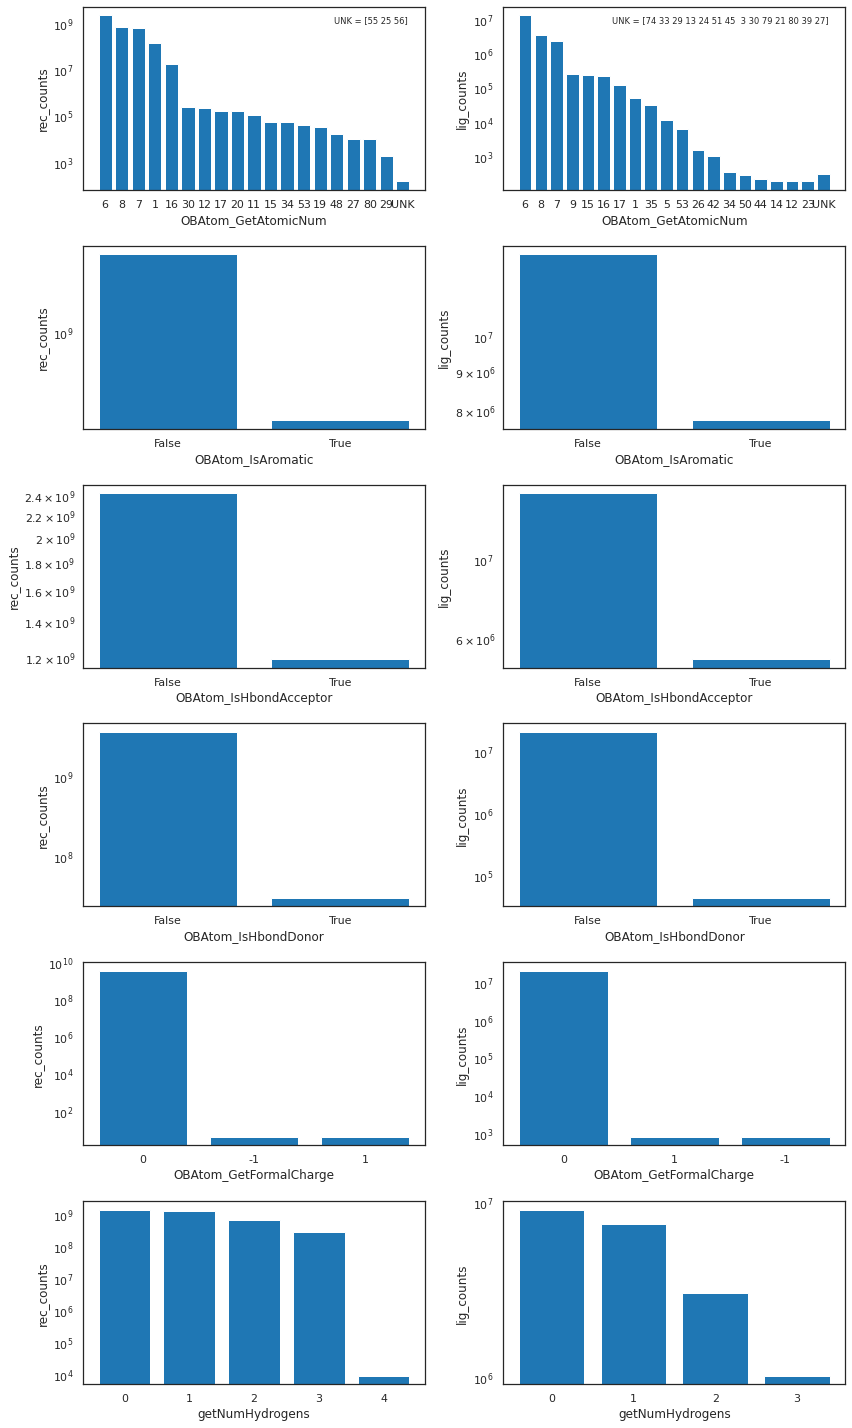

In [54]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

with open('rec_counts.pkl', 'rb') as f:
    rec_counts = pickle.load(f)
with open('lig_counts.pkl', 'rb') as f:
    lig_counts = pickle.load(f)

def plot_counts(counts, ax, thresh=0.0, symbols=False):
    
    # get labels and counts as arrays
    labels = np.array(list(counts.keys()))
    counts = np.array(list(counts.values()))
        
    # sort arrays by label
    idx = np.argsort(-counts)
    labels = labels[idx]
    counts = counts[idx]
    
    if symbols:
        labels = np.array([ob.GetSymbol(int(l)) for l in labels])
    
    # apply threshold
    idx = (counts > thresh)
    n_unk = counts[~idx].sum()
    unk_labels = labels[~idx]

    if n_unk > 0 and len(labels) > 5:
        labels = labels[idx]
        counts = counts[idx]
        labels = np.append(labels, 'UNK')
        counts = np.append(counts, n_unk)
        
    # convert counts to percents
    #counts = counts / counts.sum()
    
    x = np.arange(len(counts))
    ax.bar(x, counts)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if 'UNK' in labels:
        ax.text(0.95, 0.95, 'UNK = {}'.format(unk_labels),
            fontsize='x-small',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
        )
    if len(labels) > 20:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize('x-small')

fig, axes = plt.subplots(len(funcs), 2, figsize=(12, 20))

thresh = 100

for i, func in enumerate(funcs):
    ax = axes[i][0]
    plot_counts(rec_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('rec_counts')
    ax.set_yscale('log')

for i, func in enumerate(funcs):
    ax = axes[i][1]
    plot_counts(lig_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('lig_counts')
    ax.set_yscale('log')

fig.tight_layout()

In [138]:
for atomic_num in sorted(rec_counts[funcs[0].__name__].keys()):
    symbol = ob.GetSymbol(atomic_num)
    cov_radius = ob.GetCovalentRad(atomic_num)
    vdw_radius = ob.GetVdwRad(atomic_num)
    print('{}\t{}\t{}\t{}'.format(atomic_num, symbol, cov_radius, vdw_radius))

1	H	0.31	1.1
6	C	0.76	1.7
7	N	0.71	1.55
8	O	0.66	1.52
11	Na	1.66	2.27
12	Mg	1.41	1.73
15	P	1.07	1.8
16	S	1.05	1.8
17	Cl	1.02	1.75
19	K	2.03	2.75
20	Ca	1.76	2.31
25	Mn	1.39	2.05
27	Co	1.26	2.0
29	Cu	1.32	2.0
30	Zn	1.22	2.1
34	Se	1.2	1.9
48	Cd	1.44	2.2
53	I	1.39	1.98
55	Cs	2.44	3.43
56	Ba	2.15	2.68
80	Hg	1.32	2.05


# Bond adding experiment

In [171]:
sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

add_expt_dir = os.path.join(os.environ['LIGAN_ROOT'], 'new_atom_typing')
os.chdir(add_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing'

In [83]:
add_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_train0.types',
    n_examples= 100000,
    typer_fns = ['oad', 'oadc', 'on', 'oh'],
    use_ob_mol = [0, 1]
)
len(add_params)

8

In [176]:
name_format = 'add_{typer_fns}_{use_ob_mol}'
template_file = 'add.sh'

add_job_files = param_search.setup(
    expt_dir=add_expt_dir,
    name_format=name_format,
    template_file=template_file,
    param_space=add_params,
)
add_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oh_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oh_1/add.sh']

In [134]:
job_ids = param_search.submit(add_job_files)
print(job_ids)

[6814416, 6814417, 6814418, 6814419, 6814420, 6814421, 6814422, 6814423]


In [177]:
import pandas as pd
add_df = pd.DataFrame(dict(
    job_id=[
        [6813229, 6813230, 6813231, 6813232, 6813233, 6813234, 6813235, 6813236],
        [6813240, 6813241, 6813242, 6813243, 6813244, 6813245, 6813246, 6813247],
        [6813291, 6813292, 6813293, 6813294, 6813295, 6813296, 6813297, 6813298],
        [6814300, 6814301, 6814302, 6814303, 6814304, 6814305, 6814306, 6814307],
        [6814308, 6814309, 6814310, 6814311, 6814312, 6814313, 6814314, 6814315],
        [6814316, 6814317, 6814318, 6814319, 6814320, 6814321, 6814322, 6814323],
        [6814326, 6814327, 6814328, 6814329, 6814330, 6814331, 6814332, 6814333],
        [6814344, 6814345, 6814346, 6814347, 6814348, 6814349, 6814350, 6814351],
        [6814416, 6814417, 6814418, 6814419, 6814420, 6814421, 6814422, 6814423],
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [178]:
import numpy as np
import glob, re
import param_search

qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

add_df = add_df.merge(qstat, on='job_id', how='left')

def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    f = glob.glob('*/{}.*'.format(x['job_id']))
    if f:
        return os.path.dirname(f[0])
    # else cancelled before running

def find_job_state(x):
    if 'job_state' in x and not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=Exception, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

add_df['work_dir'] = add_df.apply(find_work_dir, axis=1)
add_df['job_name'] = add_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
add_df['job_file'] = add_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
add_df['stdout_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
add_df['stderr_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
add_df['stdout'] = add_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
add_df['stderr'] = add_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
add_df['job_state'] = add_df.apply(find_job_state, axis=1)

In [179]:
add_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stderr']]

,,runtime,node_id,job_state,stderr
job_id,job_name,,,,
6813229,add_oad_0,NaN,NaN,ERR,RuntimeError: Pre-condition Violation
6813230,add_oad_1,NaN,NaN,ERR,RuntimeError: Pre-condition Violation
6813231,add_oadc_0,NaN,NaN,ERR,RuntimeError: Pre-condition Violation
6813232,add_oadc_1,NaN,NaN,ERR,RuntimeError: Pre-condition Violation
6813233,add_on_0,NaN,NaN,ERR,RuntimeError: Pre-condition Violation
...,...,...,...,...,...
6814419,add_oadc_1,NaN,NaN,OK,None
6814420,add_on_0,NaN,NaN,OK,None
6814421,add_on_1,NaN,NaN,OK,None


In [180]:
add_metrics = param_search.metrics(add_job_files, metric_pat='(.*)metrics')
add_metrics

,example_idx,lig_name,pose_idx,n_atoms_diff,elem_count_diff,prop_count_diff,rd_sim,ob_sim,smi_match,add_time,data_root,data_file,n_examples,typer_fns,use_ob_mol,job_name
0,0,4gnt_A_rec_5f74_amp_lig_tt_min,0,0,0,0,1.0,1.0,True,0.0805,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oad,0,add_oad_0
1,1,5n10_B_rec_5f74_amp_lig_tt_min,0,0,0,0,1.0,1.0,True,0.0704,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oad,0,add_oad_0
2,2,5f74_A_rec_5f74_amp_lig_tt_min,0,0,0,0,1.0,1.0,True,0.0707,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oad,0,add_oad_0
3,3,5n10_A_rec_5f74_amp_lig_tt_min,0,0,0,0,1.0,1.0,True,0.0699,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oad,0,add_oad_0
4,4,5f74_A_rec_5f74_amp_lig_tt_docked,3,0,0,0,1.0,1.0,True,0.0694,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oad,0,add_oad_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,410,4iea_A_rec_3ux0_0dv_lig_tt_min,0,0,0,0,1.0,1.0,True,20.6074,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oh,1,add_oh_1
411,411,4qli_A_rec_3t0l_1ct_lig_tt_min,0,0,0,0,1.0,1.0,True,0.3892,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oh,1,add_oh_1
412,412,3spr_A_rec_4fr3_0v4_lig_tt_min,0,0,0,0,1.0,1.0,True,23.8055,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oh,1,add_oh_1
413,413,4dhn_A_rec_5mxo_fsc_lig_tt_min,0,0,0,0,1.0,1.0,True,59.0374,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oh,1,add_oh_1


oad  = H acceptor/donor
oadc = H acceptor/donor + formal charge
on   = number of bonded Hs
oh   = explicit H atoms


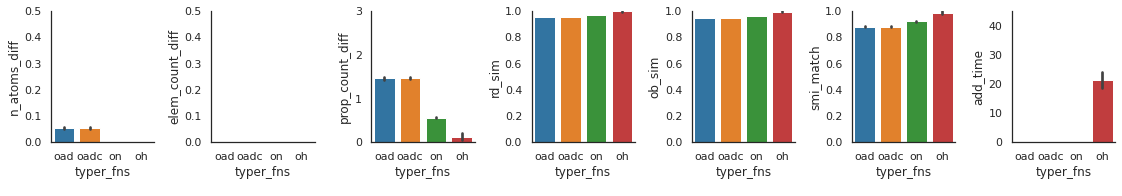

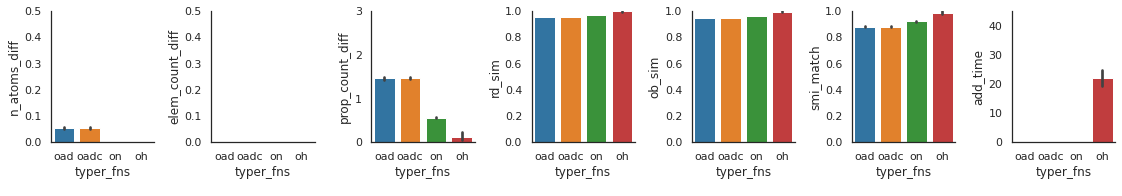

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

typer_fn_map = dict(
    oad ='H acceptor/donor',
    oadc='H acceptor/donor + formal charge',
    on  ='number of bonded Hs',
    oh  ='explicit H atoms',
)

plot_df = add_metrics.reset_index()

for use_ob_mol in [0, 1]:
    fig = param_search.plot(
        plot_df[plot_df['use_ob_mol'] == use_ob_mol],
        x='typer_fns',
        y=[
            'n_atoms_diff',
            'elem_count_diff',
            'prop_count_diff',
            'rd_sim',
            'ob_sim',
            'smi_match',
            'add_time'
        ],
        hue=None,
        n_cols=7,
        width=2.25,
        height=3,
        plot_func=sns.barplot,
        ylim=dict(
            n_atoms_diff=[0, 0.5],
            elem_count_diff=[0, 0.5],
            prop_count_diff=[0, 3],
            rd_sim=[0, 1],
            ob_sim=[0, 1],
            smi_match=[0, 1],
            add_time=[0, 45],
        )
    )

print('\n'.join(
    '{} = {}'.format(tf.ljust(4), typer_fn_map[tf]) for tf in ['oad', 'oadc', 'on', 'oh']
))

In [182]:
add_metrics.groupby(['typer_fns', 'use_ob_mol'])[['example_idx']].count()

example_idx
typer_fns use_ob_mol             
oad       0                100000
          1                100000
oadc      0                100000
          1                100000
oh        0                   431
          1                   415
on        0                100000
          1                100000

# Atom fitting experiment

In [ ]:
sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

fit_expt_dir = os.path.join(add_expt_dir, 'atom_fitting')
os.chdir(fit_expt_dir)
os.getcwd()

In [161]:
fit_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_train0.types',
    n_examples= 10,
    typer_fns = ['oad', 'oadc', 'on', 'oh'],
    radius_fn = ['v', 'c'],
    apply_prop_conv = [0, 1],
)
len(fit_params)

16

In [162]:
name_format = 'fit_{typer_fns}-{radius_fn}_{apply_prop_conv}'

for template_file in ['generate.config', 'generate.sh']:
    fit_job_files = param_search.setup(
        expt_dir=fit_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=fit_params,
    )

fit_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-v_1/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-c_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-c_1/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-v_1/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-c_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-c_1/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-v_1/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-c_0/generate.sh',
 '/net/pulsar/home/k